In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

In [2]:
from inxss.experiment import NeutronExperiment, SimulatedExperiment

In [3]:
model_path = '/pscratch/sd/z/zhantao/inxs_steering_production/models/version_14896845/checkpoints/epoch=7160-step=343728.ckpt'
data = torch.load('/pscratch/sd/z/zhantao/inxs_steering_production/experiment_data/summarized_neutron_data_w_bkg_260meV.pt')
print(data.keys())

dict_keys(['grid', 'S', 'background', 'background_dict'])


### setup experiment simulator

In [4]:
from inxss.experiment import Background

In [5]:
background = Background(
    tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), 
    data['grid']['w_grid'], 
    data['background'], 
    data['scale'],
    data['scale_separator']
)

KeyError: 'scale'

### Testing integrated steer module

In [ ]:
from inxss.steer_neutron import NeutronExperimentSteerer

In [ ]:
particle_filter_config = {
    "num_particles": 500,
    "dim_particles": 2,
    "prior_configs": {'types': ['uniform', 'uniform'], 'args': [{'low': 20, 'high': 40}, {'low': -5, 'high': 5}]}
}


grid_info = {
    'h_grid': [-2.0, 2.0, 121],
    'k_grid': [-2.0, 2.0, 121],
    'l_grid': [-10.0, 4.5, 30],
    'w_grid': [20.0, 150.0, 66]
}
# grid_info = {
#     _: [eval(f'neutron_exp.{_}').min().item(), eval(f'neutron_exp.{_}').max().item(), eval(f'neutron_exp.{_}').shape[0]] 
#     for _ in ['h_grid', 'k_grid', 'l_grid', 'w_grid']}

mask_config = {
    "raw_mask_path": '/pscratch/sd/z/zhantao/inxs_steering/La2NiO4_bool',
    "memmap_mask_path": '/pscratch/sd/z/zhantao/inxs_steering/mask_data',
    "grid_info": grid_info,
    "preload": False,
    "build_from_scratch_if_no_memmap": False,
    "global_mask": data['S']>0
}

experiment_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "S_grid": data['S'],
    "S_scale_factor": 1.
}

background_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "bkg_grid": data['background'],
    "scale": data['scale'],
    "scale_separator": data['scale_separator']
}

model = SpecNeuralRepr.load_from_checkpoint(model_path).to(device)

steer = NeutronExperimentSteerer(
    model, particle_filter_config=particle_filter_config,
    mask_config=mask_config, experiment_config=experiment_config, background_config=background_config,
    likelihood_sample_ratio=0.2, tqdm_pbar=False, device='cuda')

obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_150.0_66.npy


In [ ]:
mean_list = []
std_list = []
steer.reset()

In [ ]:
# print(data['params'][test_idx[idx_plot]])
with torch.no_grad():
    print(steer.particle_filter.mean().detach().cpu(), steer.particle_filter.std().detach().cpu()) 
    for i in tqdm(range(50)):
        steer.step_steer()
        print(steer.particle_filter.mean(), steer.particle_filter.std())
        mean_list.append(steer.particle_filter.mean().detach().cpu())
        std_list.append(steer.particle_filter.std().detach().cpu())
    
    # print(steer.particle_filter.positions[:10])
    # print(steer.particle_filter.weights[:10])

tensor([2.9802e+01, 2.7483e-02], dtype=torch.float64) tensor([5.6803, 2.8238], dtype=torch.float64)


  2%|▏         | 1/50 [00:04<03:58,  4.86s/it]

tensor([30.0452, -0.1461], dtype=torch.float64) tensor([6.0195, 2.9109], dtype=torch.float64)


  4%|▍         | 2/50 [00:09<03:48,  4.77s/it]

tensor([2.9769e+01, 6.2103e-03], dtype=torch.float64) tensor([6.1263, 2.9489], dtype=torch.float64)


  6%|▌         | 3/50 [00:14<03:42,  4.73s/it]

tensor([29.4094,  0.1002], dtype=torch.float64) tensor([6.2499, 2.9898], dtype=torch.float64)


  8%|▊         | 4/50 [00:18<03:37,  4.72s/it]

tensor([29.7509,  0.0856], dtype=torch.float64) tensor([6.4636, 3.0222], dtype=torch.float64)


 10%|█         | 5/50 [00:23<03:32,  4.72s/it]

tensor([30.9033,  0.1092], dtype=torch.float64) tensor([6.2967, 3.0998], dtype=torch.float64)


 12%|█▏        | 6/50 [00:28<03:27,  4.72s/it]

tensor([30.8511,  0.0937], dtype=torch.float64) tensor([6.3675, 3.1191], dtype=torch.float64)


 14%|█▍        | 7/50 [00:33<03:22,  4.71s/it]

tensor([31.9072, -0.4626], dtype=torch.float64) tensor([6.1476, 3.1225], dtype=torch.float64)


 16%|█▌        | 8/50 [00:37<03:18,  4.72s/it]

tensor([31.3477, -0.2447], dtype=torch.float64) tensor([6.1815, 3.1932], dtype=torch.float64)


 18%|█▊        | 9/50 [00:42<03:13,  4.73s/it]

tensor([30.9513, -0.0903], dtype=torch.float64) tensor([6.1857, 3.2057], dtype=torch.float64)


 20%|██        | 10/50 [00:47<03:09,  4.73s/it]

tensor([28.4438,  0.9502], dtype=torch.float64) tensor([5.4363, 3.0232], dtype=torch.float64)


 22%|██▏       | 11/50 [00:51<03:03,  4.71s/it]

tensor([27.0980,  1.7174], dtype=torch.float64) tensor([3.6228, 2.2813], dtype=torch.float64)


 24%|██▍       | 12/50 [00:56<02:58,  4.70s/it]

tensor([26.9955,  1.6299], dtype=torch.float64) tensor([3.5200, 2.3155], dtype=torch.float64)


 26%|██▌       | 13/50 [01:01<02:53,  4.69s/it]

tensor([27.3395,  1.5578], dtype=torch.float64) tensor([3.3382, 2.2949], dtype=torch.float64)


 28%|██▊       | 14/50 [01:05<02:48,  4.68s/it]

tensor([27.8000,  1.7308], dtype=torch.float64) tensor([3.2421, 2.2402], dtype=torch.float64)


 30%|███       | 15/50 [01:10<02:44,  4.69s/it]

tensor([27.8959,  1.4591], dtype=torch.float64) tensor([3.1485, 2.2358], dtype=torch.float64)


 32%|███▏      | 16/50 [01:15<02:39,  4.69s/it]

tensor([28.6380,  1.9817], dtype=torch.float64) tensor([2.8669, 1.9719], dtype=torch.float64)


 34%|███▍      | 17/50 [01:20<02:34,  4.69s/it]

tensor([28.3266,  1.6904], dtype=torch.float64) tensor([2.8275, 1.9694], dtype=torch.float64)


 36%|███▌      | 18/50 [01:24<02:30,  4.70s/it]

tensor([28.5864,  1.9315], dtype=torch.float64) tensor([2.7107, 1.8611], dtype=torch.float64)


 38%|███▊      | 19/50 [01:29<02:25,  4.69s/it]

tensor([28.6926,  2.0088], dtype=torch.float64) tensor([2.7802, 1.9342], dtype=torch.float64)


 40%|████      | 20/50 [01:34<02:20,  4.69s/it]

tensor([29.0542,  2.1869], dtype=torch.float64) tensor([2.5887, 1.7368], dtype=torch.float64)


 42%|████▏     | 21/50 [01:38<02:16,  4.69s/it]

tensor([28.7600,  1.9573], dtype=torch.float64) tensor([2.2471, 1.5728], dtype=torch.float64)


 44%|████▍     | 22/50 [01:43<02:11,  4.70s/it]

tensor([29.0533,  2.2355], dtype=torch.float64) tensor([2.1231, 1.4813], dtype=torch.float64)


 46%|████▌     | 23/50 [01:48<02:06,  4.69s/it]

tensor([29.2153,  2.3063], dtype=torch.float64) tensor([2.0527, 1.4406], dtype=torch.float64)


 48%|████▊     | 24/50 [01:52<02:02,  4.70s/it]

tensor([29.4528,  2.3499], dtype=torch.float64) tensor([2.0212, 1.4254], dtype=torch.float64)


 50%|█████     | 25/50 [01:57<01:57,  4.70s/it]

tensor([29.2504,  2.1561], dtype=torch.float64) tensor([1.9413, 1.3636], dtype=torch.float64)


 52%|█████▏    | 26/50 [02:02<01:52,  4.71s/it]

tensor([29.2891,  2.1350], dtype=torch.float64) tensor([1.8711, 1.3183], dtype=torch.float64)


 54%|█████▍    | 27/50 [02:07<01:48,  4.71s/it]

tensor([29.5502,  2.3033], dtype=torch.float64) tensor([1.7963, 1.2732], dtype=torch.float64)


 56%|█████▌    | 28/50 [02:11<01:43,  4.71s/it]

tensor([29.1507,  1.9224], dtype=torch.float64) tensor([1.7556, 1.2373], dtype=torch.float64)


 58%|█████▊    | 29/50 [02:16<01:38,  4.70s/it]

tensor([29.0620,  1.8168], dtype=torch.float64) tensor([1.6789, 1.1746], dtype=torch.float64)


 60%|██████    | 30/50 [02:21<01:34,  4.71s/it]

tensor([29.2285,  1.8985], dtype=torch.float64) tensor([1.5700, 1.0861], dtype=torch.float64)


 62%|██████▏   | 31/50 [02:25<01:29,  4.71s/it]

tensor([29.0529,  1.7611], dtype=torch.float64) tensor([1.5125, 1.0483], dtype=torch.float64)


 64%|██████▍   | 32/50 [02:30<01:24,  4.70s/it]

tensor([28.9439,  1.7321], dtype=torch.float64) tensor([1.5017, 1.0392], dtype=torch.float64)


 66%|██████▌   | 33/50 [02:35<01:19,  4.69s/it]

tensor([29.0982,  1.8022], dtype=torch.float64) tensor([1.4030, 0.9760], dtype=torch.float64)


 68%|██████▊   | 34/50 [02:39<01:15,  4.69s/it]

tensor([28.8986,  1.6622], dtype=torch.float64) tensor([1.3657, 0.9408], dtype=torch.float64)


 70%|███████   | 35/50 [02:44<01:10,  4.69s/it]

tensor([28.9119,  1.6211], dtype=torch.float64) tensor([1.3059, 0.9028], dtype=torch.float64)


 72%|███████▏  | 36/50 [02:49<01:05,  4.68s/it]

tensor([28.9231,  1.5964], dtype=torch.float64) tensor([1.2649, 0.8741], dtype=torch.float64)


 74%|███████▍  | 37/50 [02:53<01:00,  4.69s/it]

tensor([28.7754,  1.4551], dtype=torch.float64) tensor([1.2321, 0.8397], dtype=torch.float64)


 76%|███████▌  | 38/50 [02:58<00:56,  4.70s/it]

tensor([28.9405,  1.5793], dtype=torch.float64) tensor([1.1402, 0.7759], dtype=torch.float64)


 78%|███████▊  | 39/50 [03:03<00:52,  4.73s/it]

tensor([28.9592,  1.6248], dtype=torch.float64) tensor([1.1172, 0.7552], dtype=torch.float64)


 80%|████████  | 40/50 [03:08<00:47,  4.73s/it]

tensor([29.0843,  1.7005], dtype=torch.float64) tensor([1.0731, 0.7315], dtype=torch.float64)


 82%|████████▏ | 41/50 [03:12<00:42,  4.72s/it]

tensor([29.1536,  1.7292], dtype=torch.float64) tensor([1.0363, 0.7113], dtype=torch.float64)


 84%|████████▍ | 42/50 [03:17<00:37,  4.70s/it]

tensor([29.2205,  1.7905], dtype=torch.float64) tensor([1.0268, 0.7053], dtype=torch.float64)


 86%|████████▌ | 43/50 [03:22<00:32,  4.70s/it]

tensor([29.2790,  1.8352], dtype=torch.float64) tensor([1.0039, 0.6989], dtype=torch.float64)


 88%|████████▊ | 44/50 [03:26<00:28,  4.69s/it]

tensor([29.2038,  1.8016], dtype=torch.float64) tensor([1.0061, 0.7002], dtype=torch.float64)


 90%|█████████ | 45/50 [03:31<00:23,  4.70s/it]

tensor([29.3307,  1.9005], dtype=torch.float64) tensor([0.9841, 0.6930], dtype=torch.float64)


 92%|█████████▏| 46/50 [03:36<00:18,  4.72s/it]

tensor([29.2068,  1.8033], dtype=torch.float64) tensor([1.0292, 0.7136], dtype=torch.float64)


 94%|█████████▍| 47/50 [03:41<00:14,  4.72s/it]

tensor([29.0948,  1.7032], dtype=torch.float64) tensor([0.9758, 0.6741], dtype=torch.float64)


 96%|█████████▌| 48/50 [03:45<00:09,  4.71s/it]

tensor([29.1481,  1.7139], dtype=torch.float64) tensor([0.9324, 0.6467], dtype=torch.float64)


 98%|█████████▊| 49/50 [03:50<00:04,  4.69s/it]

tensor([28.9960,  1.5996], dtype=torch.float64) tensor([0.9063, 0.6185], dtype=torch.float64)


100%|██████████| 50/50 [03:55<00:00,  4.71s/it]

tensor([28.9090,  1.5582], dtype=torch.float64) tensor([0.8926, 0.6048], dtype=torch.float64)


In [ ]:
means = torch.vstack(mean_list).detach().numpy()[:]
std_dev = torch.vstack(std_list).detach().numpy()[:]

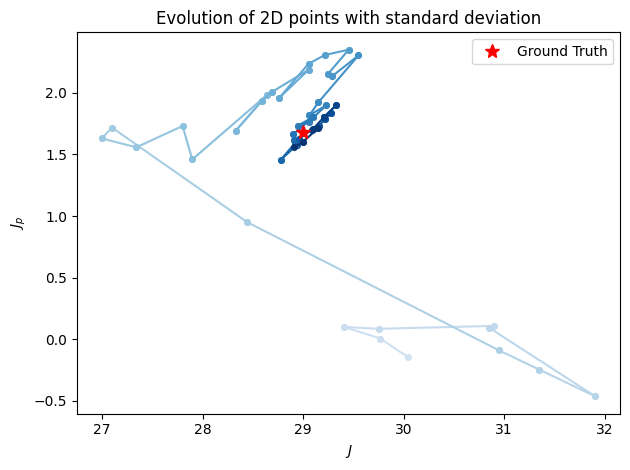

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create some dummy data
scale_factor = 0.25
N = means.shape[0]
# means = np.cumsum(np.random.randn(N, 2), axis=0)
# stds = np.abs(np.random.randn(N, 2))

# Visualization
fig, ax = plt.subplots()

cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0.2, 1, N)]

# Plot the evolution of the points with colormap
for i in range(N-1):
    ax.plot(means[i:i+2, 0], means[i:i+2, 1], '-o', color=colors[i], markersize=4)


# # Plot ovals for standard deviation
# for i in range(N):
#     ellipse = patches.Ellipse((means[i, 0], means[i, 1]),
#                               width=std_dev[i, 0]*scale_factor,  
#                               height=std_dev[i, 1]*scale_factor,
#                               edgecolor=None, facecolor=colors[i], alpha=0.2)  
#     ax.add_patch(ellipse)

ax.plot(29.0, 1.68, '*', label='Ground Truth', markersize=10, color='red')

ax.set_title('Evolution of 2D points with standard deviation')
ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')
# ax.set_xlim(20, 40)
# ax.set_ylim(-5, 5)
ax.legend()

plt.tight_layout()
plt.show()


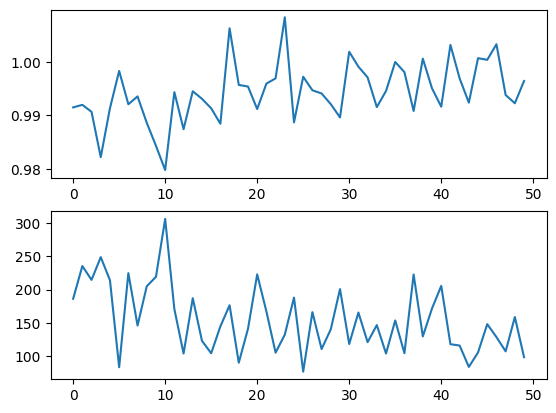

In [ ]:
fig, axes = plt.subplots(2,1)
axes[0].plot(torch.stack(steer.sig_bkg_factors).numpy()[:,0])
axes[1].plot(torch.stack(steer.sig_bkg_factors).numpy()[:,1])